
Install and import all required libraries and modules for deep learning, data processing, and model evaluation.










In [ ]:
# Install necessary libraries
!pip install keras-tuner -q

# Import necessary libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import keras_tuner as kt

warnings.filterwarnings('ignore', category=FutureWarning)
tf.get_logger().setLevel('ERROR')

Download the dataset using Kaggle Hub, load it into a DataFrame, and perform initial exploration and preprocessing including missing value handling.

In [ ]:
# --- 1. Data Loading ---
print("--- 1. Data Loading ---")
try:
    print("Downloading dataset via Kaggle Hub...")
    path = kagglehub.dataset_download("smokingkrils/temperature-forecast-project-using-ml")
    file_path = os.path.join(path, "temp.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError("Could not find the CSV file.")
except Exception as e:
    print(f"Error downloading or finding dataset: {e}")
    file_path = "/root/.cache/kagglehub/datasets/smokingkrils/temperature-forecast-project-using-ml/versions/1/temp.csv"

print(f"Attempting to load data from: {file_path}")
df = pd.read_csv(file_path)
print("Dataset loaded successfully.")


# --- 2. Initial Data Exploration & Preprocessing ---
print("\n--- 2. Initial Data Exploration & Preprocessing ---")
print("\nOriginal Data Info:")
df.info()

print("\nInitial Missing Values:")
print(df.isnull().sum())

print("\nOriginal Data Description:")
# Increase float precision for describe
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df.describe())
pd.reset_option('display.float_format') # Reset to default

# Drop rows with missing station and date (critical identifiers)
print(f"\nShape before dropping missing station/Date: {df.shape}")
# Check if 'station' column exists before dropping
if 'station' in df.columns:
    df.dropna(subset=['station', 'Date'], inplace=True)
else:
    print("Warning: 'station' column not found. Dropping NaNs based on 'Date' only.")
    df.dropna(subset=['Date'], inplace=True)
print(f"Shape after dropping missing station/Date: {df.shape}")

--- 1. Data Loading ---


100%|██████████| 639k/639k [00:00<00:00, 29.8MB/s]

Extracting files...
Attempting to load data from: /root/.cache/kagglehub/datasets/smokingkrils/temperature-forecast-project-using-ml/versions/1/temp.csv
Dataset loaded successfully.

--- 2. Initial Data Exploration & Preprocessing ---

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         767

       station  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
count 7750.000      7682.000      7682.000     7677.000     7677.000   
mean    13.000        29.768        23.225       56.759       88.375   
std      7.212         2.970         2.414       14.668        7.192   
min      1.000        20.000        11.300       19.795       58.936   
25%      7.000        27.800        21.700       45.964       84.223   
50%     13.000        29.900        23.400       55.039       89.793   
75%     19.000        32.000        24.900       67.190       93.744   
max     25.000        37.600        29.900       98.525      100.000   

       LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS  LDAPS_LH  LDAPS_CC1  ...  \
count          7677.000          7677.000  7677.000  7677.000   7677.000  ...   
mean             29.613            23.513     7.098    62.505      0.369  ...   
std               2.947             2.345     2.184    33.731      0.262  ...   
min              17.625    

Select relevant numerical columns, handle missing values using mean imputation, and convert the 'Date' column to datetime format.

In [ ]:
# Define numerical weather columns for imputation (Ensure all are actually present)
all_cols = df.columns.tolist()
weather_columns = [
    'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
    'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
    'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
    'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4',
    'lat', 'lon', 'DEM', 'Slope', # Added geographical features if they exist and are numeric
    'Solar_radiation',
    'Next_Tmax', 'Next_Tmin'
]

# Filter weather_columns to only include columns actually present in the DataFrame
weather_columns = [col for col in weather_columns if col in df.columns]
print(f"\nNumerical columns selected for imputation: {weather_columns}")

# Fill remaining missing numerical values with the mean
print("\nFilling missing numerical values with mean...")
for col in weather_columns:
    if df[col].isnull().any():
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)

print("\nMissing Values After Handling:")
print(df.isnull().sum()) # Check remaining NaNs

# Convert 'Date' column to datetime objects
print("\nConverting 'Date' column to datetime...")
try:
    # Attempt standard format first
    df['Date'] = pd.to_datetime(df['Date'])
except ValueError:
    print("Standard datetime parsing failed, trying dayfirst=True...")
    # Fallback to dayfirst=True if standard fails (based on original code)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


print("\nData Types After Conversion:")
print(df.dtypes)


Numerical columns selected for imputation: ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope', 'Next_Tmax', 'Next_Tmin']

Filling missing numerical values with mean...

Missing Values After Handling:
station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

Converting 'Date' colu

<ipython-input-4-bae27fd08839>:31: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


Perform exploratory data analysis using visualizations such as distribution plots, correlation matrix, and time series trends of target temperature variables.


--- 3. Exploratory Data Analysis (Visualizations) ---


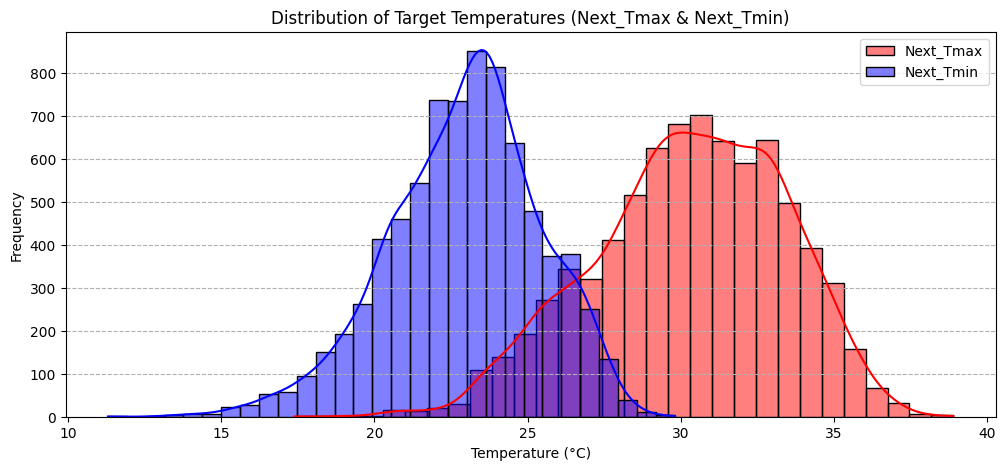

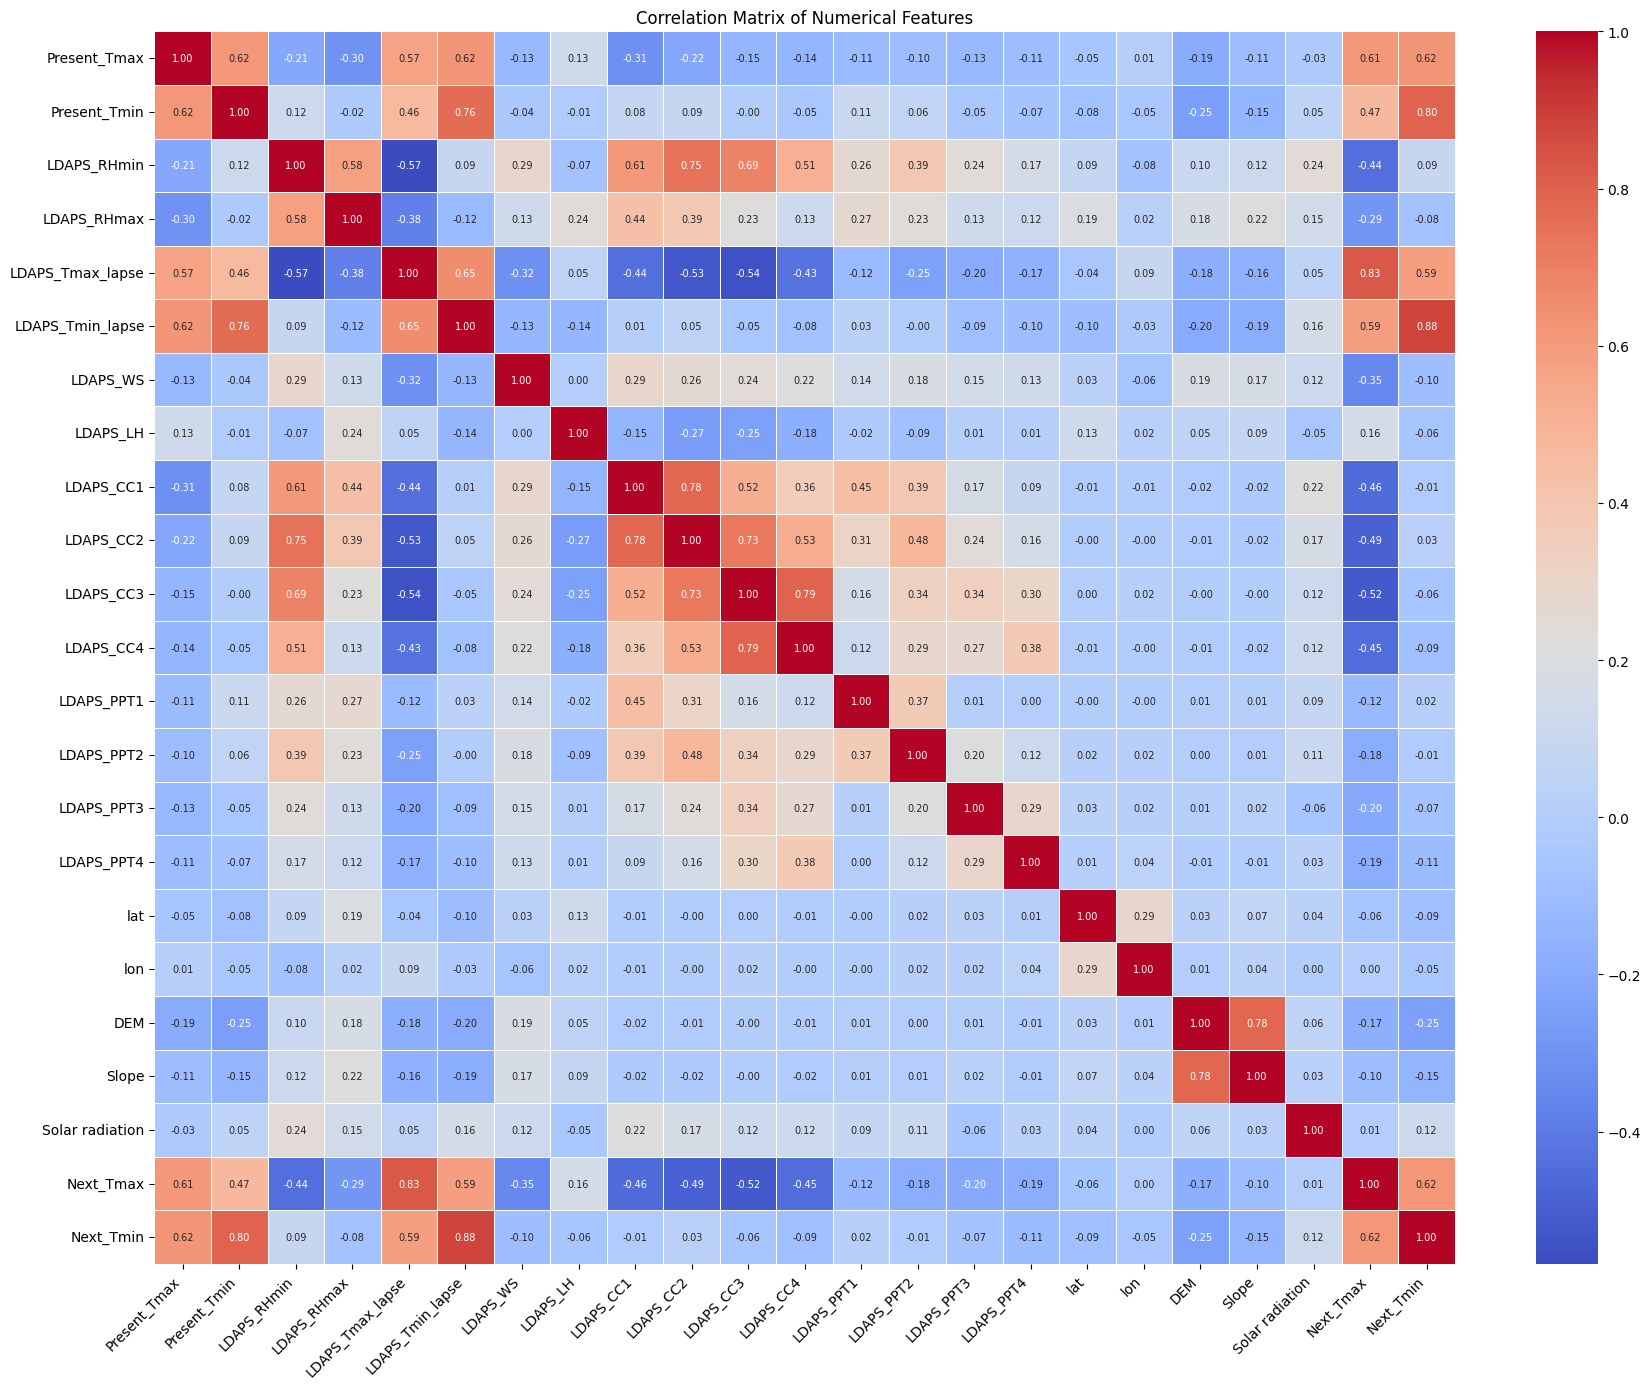

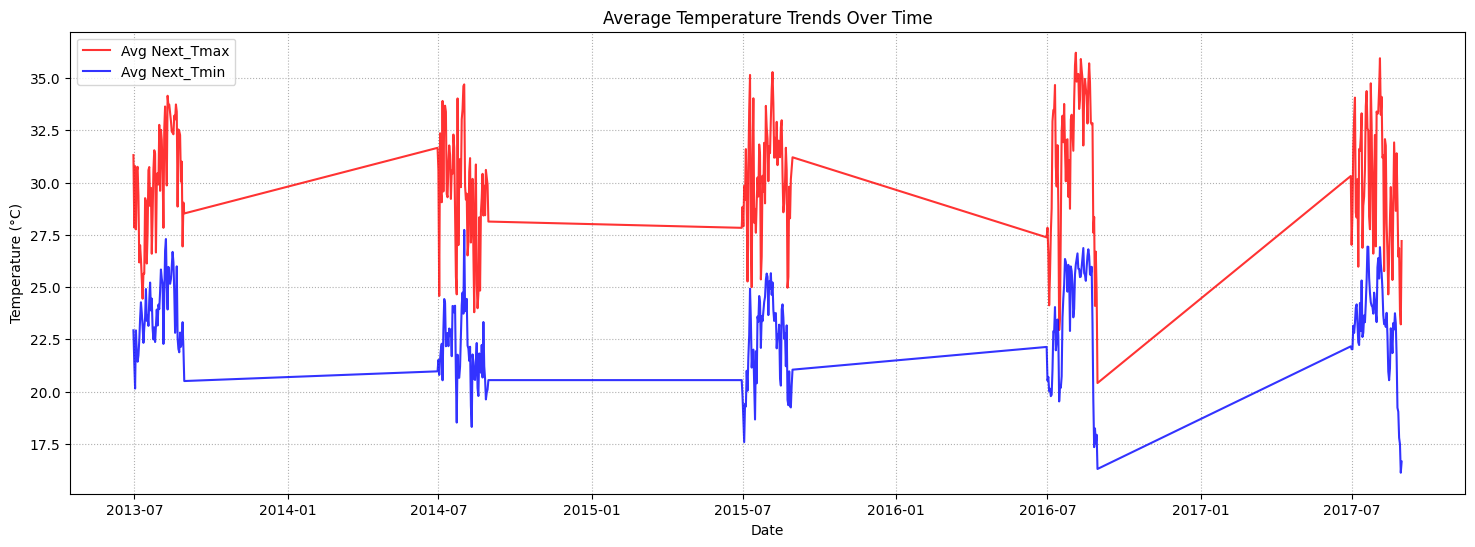


Available columns for feature selection: ['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin']


In [ ]:
# --- 3. Exploratory Data Analysis (Visualizations) ---
print("\n--- 3. Exploratory Data Analysis (Visualizations) ---")

# Distribution Plot
plt.figure(figsize=(12, 5))
sns.histplot(df['Next_Tmax'].dropna(), bins=30, kde=True, color='red', label='Next_Tmax')
sns.histplot(df['Next_Tmin'].dropna(), bins=30, kde=True, color='blue', label='Next_Tmin')
plt.legend()
plt.title('Distribution of Target Temperatures (Next_Tmax & Next_Tmin)')
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--')
plt.show()

# Correlation Matrix (on numerical columns only)
plt.figure(figsize=(18, 14)) # Increased size slightly more
numerical_df = df.select_dtypes(include=np.number)
# Drop station if it was numeric but not relevant for correlation sense
if 'station' in numerical_df.columns:
    numerical_df = numerical_df.drop(columns=['station'])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 7}, linewidths=.5) # Smaller annotations, added lines
plt.title("Correlation Matrix of Numerical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

# Time Series Plot
plt.figure(figsize=(18, 6)) # Wider plot
df_sorted = df.sort_values('Date')
# Plot average temperature per day if multiple stations exist
if 'station' in df.columns and df['station'].nunique() > 1:
    daily_avg = df_sorted.groupby('Date')[['Next_Tmax', 'Next_Tmin']].mean().reset_index()
    plt.plot(daily_avg['Date'], daily_avg['Next_Tmax'], label="Avg Next_Tmax", color="red", alpha=0.8, linewidth=1.5)
    plt.plot(daily_avg['Date'], daily_avg['Next_Tmin'], label="Avg Next_Tmin", color="blue", alpha=0.8, linewidth=1.5)
    plt.title("Average Temperature Trends Over Time")
else:
    # Plot directly if only one station or station column doesn't exist
    plt.plot(df_sorted['Date'], df_sorted['Next_Tmax'], label="Next_Tmax", color="red", alpha=0.7, linewidth=1)
    plt.plot(df_sorted['Date'], df_sorted['Next_Tmin'], label="Next_Tmin", color="blue", alpha=0.7, linewidth=1)
    plt.title("Temperature Trends Over Time")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True, linestyle=':')
plt.show()

print("\nAvailable columns for feature selection:", df.columns.tolist())

Select relevant features and target variables, then scale the input features using MinMaxScaler for model readiness.

In [ ]:
# --- 4. Feature Selection and Scaling for Models ---
print("\n--- 4. Feature Selection and Scaling for Models ---")

# Define features based on analysis (high correlation, domain knowledge)
feature_cols = [
    'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
    'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
    'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
    'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4'
    # Consider adding 'Solar_radiation', 'DEM', 'Slope', 'lat', 'lon' if they exist and seem relevant
]
# Ensure selected feature columns actually exist in the dataframe
feature_cols = [col for col in feature_cols if col in df.columns]

if not feature_cols:
    raise ValueError("No feature columns selected or available in the DataFrame.")

print(f"\nSelected features for modeling: {feature_cols}")

target_cols = ['Next_Tmax', 'Next_Tmin']

# Extract features (X) and target variables (y)
X = df[feature_cols].values
y = df[target_cols].values

# Normalize the features using MinMaxScaler (scales features to [0, 1])
print("\nScaling features using MinMaxScaler...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(f"Features scaled. Shape: {X_scaled.shape}")


--- 4. Feature Selection and Scaling for Models ---

Selected features for modeling: ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4']

Scaling features using MinMaxScaler...
Features scaled. Shape: (7750, 16)


Data Splitting:

Split the dataset into training and testing sets, with 20% of the data reserved for testing. Shuffling is performed to ensure randomness in splitting.

Reshaping Data for LSTM, GRU, and RNN Input:

Reshape the data into a 3D format suitable for time-series models like LSTM, GRU, or RNN. The data is split into timesteps with features per timestep calculated based on the number of features.

Model Training Configuration:

Define the training configuration, including the number of epochs, batch size, optimizer, loss function, and early stopping criteria. This ensures the model is trained effectively with optimal hyperparameters.



In [ ]:
# --- 5. Data Splitting ---
print("\n--- 5. Data Splitting ---")
# Split data, ensuring shuffling for non-time-series dependent training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
print(f"Train data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

# --- 6. Reshape Data for LSTM, GRU, and RNN Input ---
print("\n--- 6. Reshape Data for LSTM, GRU, and RNN Input ---")
num_features_total = X_train.shape[1]
timesteps = 4  # Starting choice

if num_features_total % timesteps != 0:
    possible_timesteps = [t for t in range(1, num_features_total + 1) if num_features_total % t == 0]
    valid_factors = [f for f in possible_timesteps if f > 1]
    timesteps = valid_factors[0] if valid_factors else 1
    print(f"Automatically adjusting timesteps to {timesteps}.")

features_per_timestep = num_features_total // timesteps
print(f"Reshaping with {timesteps} timesteps and {features_per_timestep} features per timestep.")

X_train_reshaped = X_train.reshape((X_train.shape[0], timesteps, features_per_timestep))
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, features_per_timestep))

print(f"Reshaped Train data shape: {X_train_reshaped.shape}")
print(f"Reshaped Test data shape: {X_test_reshaped.shape}")

# Shared settings
EPOCHS = 100
BATCH_SIZE = 64
PATIENCE = 5
OPTIMIZER = 'adam'
LOSS = 'mse'
METRICS = ['mae']

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)


--- 5. Data Splitting ---
Train data shape: X=(6200, 16), y=(6200, 2)
Test data shape: X=(1550, 16), y=(1550, 2)

--- 6. Reshape Data for LSTM, GRU, and RNN Input ---
Reshaping with 4 timesteps and 4 features per timestep.
Reshaped Train data shape: (6200, 4, 4)
Reshaped Test data shape: (1550, 4, 4)


LSTM Hyperparameter Tuning: Tune LSTM model's units, dropout, and dense layers using Keras Tuner for optimal performance based on validation loss.

Hybrid LSTM + GRU Hyperparameter Tuning: Optimize a hybrid LSTM + GRU model’s units, dropout, and dense layers, selecting the best model via validation loss.

SimpleRNN Hyperparameter Tuning: Tune SimpleRNN model’s units, dropout, and dense layers to find the best model based on validation loss.

In [ ]:
# --- 7. Hyperparameter Tuning for LSTM using Keras Tuner ---
print("\n--- 7. Hyperparameter Tuning for LSTM Model ---")

def build_lstm_model(hp):
    model = Sequential()

    # Tune number of units in the first LSTM layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=16)
    model.add(LSTM(units=hp_units1, return_sequences=True, input_shape=(timesteps, features_per_timestep)))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    # Tune number of units in the second LSTM layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(LSTM(units=hp_units2, return_sequences=False))

    # Dense Layers
    model.add(Dense(units=hp.Int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(y_train.shape[1]))  # Output: Tmax, Tmin

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    return model

# Initialize tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='lstm_hyper_tuning'
)

# Search for best hyperparameters
tuner.search(X_train_reshaped, y_train,
             validation_data=(X_test_reshaped, y_test),
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             callbacks=[early_stopping],
             verbose=1)

# Get the best model
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:")
print(f"  units1: {best_hp.get('units1')}")
print(f"  dropout1: {best_hp.get('dropout1')}")
print(f"  units2: {best_hp.get('units2')}")
print(f"  dense_units: {best_hp.get('dense_units')}")

best_lstm_model = tuner.hypermodel.build(best_hp)


# --- 7A. Hyperparameter Tuning for Hybrid LSTM + GRU Model ---
print("\n--- 7A. Hyperparameter Tuning for Hybrid (LSTM + GRU) Model ---")

def build_hybrid_model(hp):
    model = Sequential()
    hp_lstm_units = hp.Int('lstm_units', 32, 128, step=16)
    model.add(LSTM(hp_lstm_units, return_sequences=True, input_shape=(timesteps, features_per_timestep)))
    model.add(Dropout(hp.Float('dropout_lstm', 0.2, 0.5, step=0.1)))

    hp_gru_units = hp.Int('gru_units', 16, 128, step=16)
    model.add(GRU(hp_gru_units, return_sequences=False))

    model.add(Dense(hp.Int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(y_train.shape[1]))

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    return model

hybrid_tuner = kt.RandomSearch(
    build_hybrid_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='hybrid_hyper_tuning'
)

hybrid_tuner.search(X_train_reshaped, y_train,
                    validation_data=(X_test_reshaped, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=1)

best_hybrid_hp = hybrid_tuner.get_best_hyperparameters(1)[0]
best_hybrid_model = hybrid_tuner.hypermodel.build(best_hybrid_hp)

# Train best Hybrid model
print("\nTraining Best Hybrid Model from Tuner...")
hybrid_tuned_history = best_hybrid_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# --- 7B. Hyperparameter Tuning for SimpleRNN ---
print("\n--- 7B. Hyperparameter Tuning for SimpleRNN Model ---")

def build_rnn_model(hp):
    model = Sequential()
    hp_rnn1 = hp.Int('rnn1_units', 32, 128, step=16)
    model.add(SimpleRNN(hp_rnn1, return_sequences=True, input_shape=(timesteps, features_per_timestep)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    hp_rnn2 = hp.Int('rnn2_units', 16, 64, step=16)
    model.add(SimpleRNN(hp_rnn2, return_sequences=False))

    model.add(Dense(hp.Int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(y_train.shape[1]))

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    return model

rnn_tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='rnn_hyper_tuning'
)

rnn_tuner.search(X_train_reshaped, y_train,
                 validation_data=(X_test_reshaped, y_test),
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 callbacks=[early_stopping],
                 verbose=1)

best_rnn_hp = rnn_tuner.get_best_hyperparameters(1)[0]
best_rnn_model = rnn_tuner.hypermodel.build(best_rnn_hp)

# Train best RNN model
print("\nTraining Best RNN Model from Tuner...")
rnn_tuned_history = best_rnn_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)


Trial 5 Complete [00h 00m 45s]
val_loss: 1.3461706638336182

Best val_loss So Far: 1.2468736171722412
Total elapsed time: 00h 03m 17s

Training Best RNN Model from Tuner...
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 452.1205 - mae: 20.1523 - val_loss: 10.4602 - val_mae: 2.6932
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4912 - mae: 2.3425 - val_loss: 7.6449 - val_mae: 2.2107
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0731 - mae: 2.2693 - val_loss: 7.6379 - val_mae: 2.2067
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8984 - mae: 2.2391 - val_loss: 6.7434 - val_mae: 2.0783
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6545 - mae: 1.8891 - val_loss: 3.4432 - val_mae: 1.4807
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5654 - mae: 1.4869 - val_loss: 2.9077 - val_mae: 1.3407
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7791 - mae: 1.3145 - val_loss: 2.0660 - val_mae: 1.1175
Epo

Training Best LSTM Model from Tuner: The best hyperparameters from Keras Tuner are used to train the optimal LSTM model, monitoring validation loss for early stopping.

Create and Train Regular LSTM Model: A standard LSTM model is created with 2 LSTM layers and dense layers, then trained using the defined parameters and early stopping.

In [ ]:
# --- 8. Training Best LSTM Model from Tuner ---
print("\n--- 8. Training Best LSTM Model from Tuner ---")

lstm_tuned_history = best_lstm_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# --- 9. Create and Train Regular LSTM Model ---
print("\n--- 9. Create and Train Regular LSTM Model ---")
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, features_per_timestep)),
    Dropout(0.3),
    LSTM(50, return_sequences=False), # Last LSTM layer returns single output
    Dense(25, activation='relu'),
    Dense(y_train.shape[1]) # Output layer with 2 neurons (Tmax, Tmin)
])

lstm_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
print("LSTM Model Summary:")
lstm_model.summary()

print("\nTraining LSTM Model...")
lstm_history = lstm_model.fit(X_train_reshaped, y_train,
                              validation_data=(X_test_reshaped, y_test),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              callbacks=[early_stopping], # Use the defined callback
                              verbose=1)


--- 8. Training Best LSTM Model from Tuner ---
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 616.0399 - mae: 24.1898 - val_loss: 187.0773 - val_mae: 13.2094
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 119.0310 - mae: 10.0729 - val_loss: 13.6706 - val_mae: 3.0739
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.4922 - mae: 2.6424 - val_loss: 7.6031 - val_mae: 2.2051
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1824 - mae: 2.2799 - val_loss: 7.6001 - val_mae: 2.2040
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.1147 - mae: 2.2743 - val_loss: 7.6062 - val_mae: 2.2076
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9114 - mae: 2.2537 - val_loss: 7.5961 - val_mae: 2.2040
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7720 - mae: 2.2200 - val_loss: 7.5952 - val_mae: 2.2048
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8140 - mae: 2.2308 - val_loss: 7.5871 - val_mae: 2.2016
Ep

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 100)         │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,527 (287.21 KB)

 Trainable params: 73,527 (287.21 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model...
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 579.6094 - mae: 23.3355 - val_loss: 80.3251 - val_mae: 8.5330
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 38.8666 - mae: 5.3747 - val_loss: 7.6228 - val_mae: 2.2169
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.1332 - mae: 2.2655 - val_loss: 7.6087 - val_mae: 2.2075
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9000 - mae: 2.2437 - val_loss: 7.5967 - val_mae: 2.2038
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6613 - mae: 2.1916 - val_loss: 7.5940 - val_mae: 2.2038
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9285 - mae: 2.2453 - val_loss: 7.5879 - val_mae: 2.2009
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9020 - mae: 2.2348 - val_loss: 7.5926 - val_mae: 2.2049
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0485 - mae: 2.2567 - val_loss: 7.6115 - val_mae: 2.2133
Epoch 9/100
97/97 ━━━━━━━━━

Create and Train Hybrid Model (LSTM + GRU): A hybrid model combining LSTM and GRU layers is built, with LSTM followed by GRU and dense layers, and trained with early stopping to optimize performance

In [ ]:
# --- 10. Create and Train Hybrid Model (LSTM + GRU) ---
print("\n--- 10. Create and Train Hybrid Model (LSTM + GRU) ---")
hybrid_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, features_per_timestep)),
    Dropout(0.3),
    GRU(50, return_sequences=False), # GRU layer after LSTM
    Dense(25, activation='relu'),
    Dense(y_train.shape[1]) # Output layer
])

hybrid_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
print("\nHybrid (LSTM+GRU) Model Summary:")
hybrid_model.summary()

print("\nTraining Hybrid Model...")
hybrid_history = hybrid_model.fit(X_train_reshaped, y_train,
                                 validation_data=(X_test_reshaped, y_test),
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 callbacks=[early_stopping], # Use the defined callback
                                 verbose=1)



--- 10. Create and Train Hybrid Model (LSTM + GRU) ---

Hybrid (LSTM+GRU) Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4, 100)         │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,127 (258.31 KB)

 Trainable params: 66,127 (258.31 KB)

 Non-trainable params: 0 (0.00 B)


Training Hybrid Model...
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 536.0330 - mae: 22.1423 - val_loss: 32.8207 - val_mae: 5.1030
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 16.6511 - mae: 3.3590 - val_loss: 7.6548 - val_mae: 2.2121
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0185 - mae: 2.2548 - val_loss: 7.6568 - val_mae: 2.2078
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1201 - mae: 2.2712 - val_loss: 7.6472 - val_mae: 2.2086
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.0176 - mae: 2.2534 - val_loss: 7.6463 - val_mae: 2.2102
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.0111 - mae: 2.2581 - val_loss: 7.6479 - val_mae: 2.2107
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.9436 - mae: 2.2399 - val_loss: 7.6489 - val_mae: 2.2133
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9631 - mae: 2.2576 - val_loss: 7.6419 - val_mae: 2.2110
Epoch 9/100
97/97 ━━━━━━━

Create and Train RNN Model: A SimpleRNN model is created with two RNN layers, followed by dense layers, and trained using early stopping to prevent overfitting.

In [ ]:
# --- 11. Create and Train RNN Model ---
print("\n--- 11. Create and Train RNN Model ---")
rnn_model = Sequential([
    SimpleRNN(100, return_sequences=True, input_shape=(timesteps, features_per_timestep)),
    Dropout(0.3),
    SimpleRNN(50, return_sequences=False), # Last RNN layer
    Dense(25, activation='relu'),
    Dense(y_train.shape[1]) # Output layer
])

rnn_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
print("\nSimpleRNN Model Summary:")
rnn_model.summary()

print("\nTraining SimpleRNN Model...")
rnn_history = rnn_model.fit(X_train_reshaped, y_train,
                            validation_data=(X_test_reshaped, y_test),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            callbacks=[early_stopping], # Use the defined callback
                            verbose=1)


--- 11. Create and Train RNN Model ---

SimpleRNN Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 4, 100)         │        10,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,377 (75.69 KB)

 Trainable params: 19,377 (75.69 KB)

 Non-trainable params: 0 (0.00 B)


Training SimpleRNN Model...
Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 457.7472 - mae: 20.2560 - val_loss: 104.2193 - val_mae: 8.4673
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 65.7441 - mae: 6.3741 - val_loss: 12.3426 - val_mae: 2.7839
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9198 - mae: 2.5176 - val_loss: 7.6953 - val_mae: 2.2191
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9413 - mae: 2.2397 - val_loss: 7.6437 - val_mae: 2.2119
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0533 - mae: 2.2607 - val_loss: 7.1555 - val_mae: 2.1485
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6671 - mae: 2.0665 - val_loss: 4.3855 - val_mae: 1.6548
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3725 - mae: 1.6692 - val_loss: 3.2542 - val_mae: 1.4315
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4992 - mae: 1.4866 - val_loss: 2.7831 - val_mae: 1.3218
Epoch 9/100
97/97 ━━━━━━━━━

Evaluate All Best-Tuned Models: The performance of the best-tuned models (Tuned LSTM, Tuned Hybrid LSTM+GRU, and Tuned SimpleRNN) is evaluated based on metrics like MSE, MAE, and R². Results are summarized in a DataFrame and sorted by MAE

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{model_name} Performance:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² : {r2:.4f}")
    return mse, mae, r2, predictions

In [ ]:
# Evaluate all best-tuned models
lstm_tuned_mse, lstm_tuned_mae, lstm_tuned_r2, lstm_tuned_predictions = evaluate_model(best_lstm_model, X_test_reshaped, y_test, "Tuned LSTM")
hybrid_tuned_mse, hybrid_tuned_mae, hybrid_tuned_r2, hybrid_tuned_predictions = evaluate_model(best_hybrid_model, X_test_reshaped, y_test, "Tuned Hybrid (LSTM+GRU)")
rnn_tuned_mse, rnn_tuned_mae, rnn_tuned_r2, rnn_tuned_predictions = evaluate_model(best_rnn_model, X_test_reshaped, y_test, "Tuned SimpleRNN")

# Summary DataFrame
results_summary = pd.DataFrame({
    'Model': ['Tuned LSTM', 'Tuned Hybrid (LSTM+GRU)', 'Tuned SimpleRNN'],
    'MSE': [lstm_tuned_mse, hybrid_tuned_mse, rnn_tuned_mse],
    'MAE': [lstm_tuned_mae, hybrid_tuned_mae, rnn_tuned_mae],
    'R²': [lstm_tuned_r2, hybrid_tuned_r2, rnn_tuned_r2]
}).sort_values(by='MAE').reset_index(drop=True)

print(results_summary)



49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Tuned LSTM Performance:
  MSE: 1.5719
  MAE: 0.9586
  R² : 0.8019
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Tuned Hybrid (LSTM+GRU) Performance:
  MSE: 1.7322
  MAE: 1.0083
  R² : 0.7818
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Tuned SimpleRNN Performance:
  MSE: 1.5177
  MAE: 0.9555
  R² : 0.8069
                     Model       MSE       MAE        R²
0          Tuned SimpleRNN  1.517706  0.955545  0.806935
1               Tuned LSTM  1.571891  0.958604  0.801885
2  Tuned Hybrid (LSTM+GRU)  1.732181  1.008321  0.781836


The code evaluates and compares the performance of the best-tuned models (Tuned LSTM, Tuned Hybrid (LSTM+GRU), and Tuned SimpleRNN) by calculating MSE, MAE, and R². It displays the results in a summary table sorted by MAE. Then, a bar chart is created to visualize and compare the performance of the models based on these metrics.

Here is the summary of the code:

Evaluation Results Summary: The performance metrics (MSE, MAE, R²) for the three models are displayed in a sorted table, and the best-performing model is identified based on the lowest MAE.

Model Performance Comparison Bar Chart: A bar chart is generated to visualize the comparison of the models' performance metrics (MSE, MAE, R²), with values displayed on top of the bars for better readability.


--- 13. Evaluation Results Summary ---
                     Model     MSE     MAE      R²
0          Tuned SimpleRNN  1.5177  0.9555  0.8069
1               Tuned LSTM  1.5719  0.9586  0.8019
2  Tuned Hybrid (LSTM+GRU)  1.7322  1.0083  0.7818

Best performing model based on MAE: Tuned SimpleRNN

--- 14. Model Performance Comparison (Bar Chart) ---


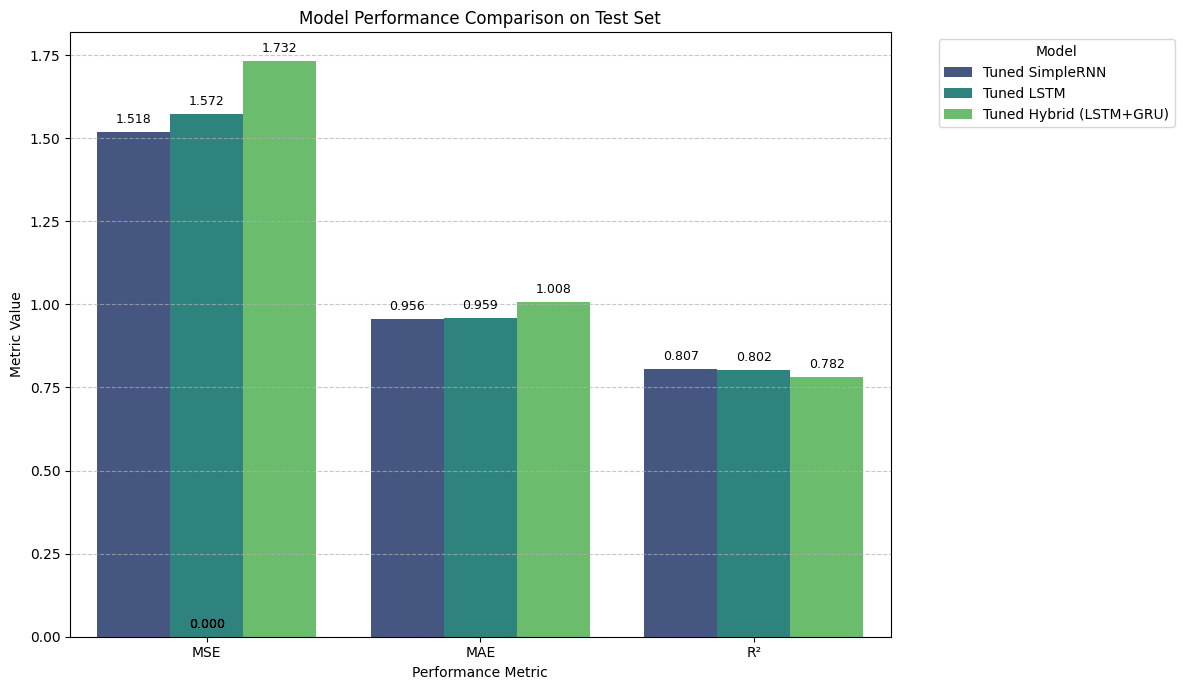

In [ ]:
# --- 13. Evaluation Results Summary ---
print("\n--- 13. Evaluation Results Summary ---")
results_summary = pd.DataFrame({
    'Model': ['Tuned LSTM', 'Tuned Hybrid (LSTM+GRU)', 'Tuned SimpleRNN'],
    'MSE': [lstm_tuned_mse, hybrid_tuned_mse, rnn_tuned_mse],
    'MAE': [lstm_tuned_mae, hybrid_tuned_mae, rnn_tuned_mae],
    'R²': [lstm_tuned_r2, hybrid_tuned_r2, rnn_tuned_r2]
})

# Sort and display
results_summary = results_summary.sort_values(by='MAE').reset_index(drop=True)
print(results_summary.round(4))

# Identify best model by MAE
best_model_name = results_summary.loc[0, 'Model']
print(f"\nBest performing model based on MAE: {best_model_name}")


# --- 14. Model Performance Comparison Bar Chart ---
print("\n--- 14. Model Performance Comparison (Bar Chart) ---")

# Prepare data for plotting (melt the DataFrame)
results_melted = pd.melt(results_summary, id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Metric', y='Value', hue='Model', data=results_melted, palette='viridis')

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), # Format to 3 decimal places
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points',
                   fontsize=9)

plt.title('Model Performance Comparison on Test Set')
plt.ylabel('Metric Value')
plt.xlabel('Performance Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The code generates and compares the training loss (MSE) and mean absolute error (MAE) for four models (Tuned LSTM, LSTM, Hybrid, and RNN) across epochs. It visualizes both training and validation metrics, highlighting the model performance trends during training with Early Stopping. The plots are styled with distinct colors for each model and adjusted for optimal visibility


--- 15. Plotting Training History (Only Tuned Models) ---


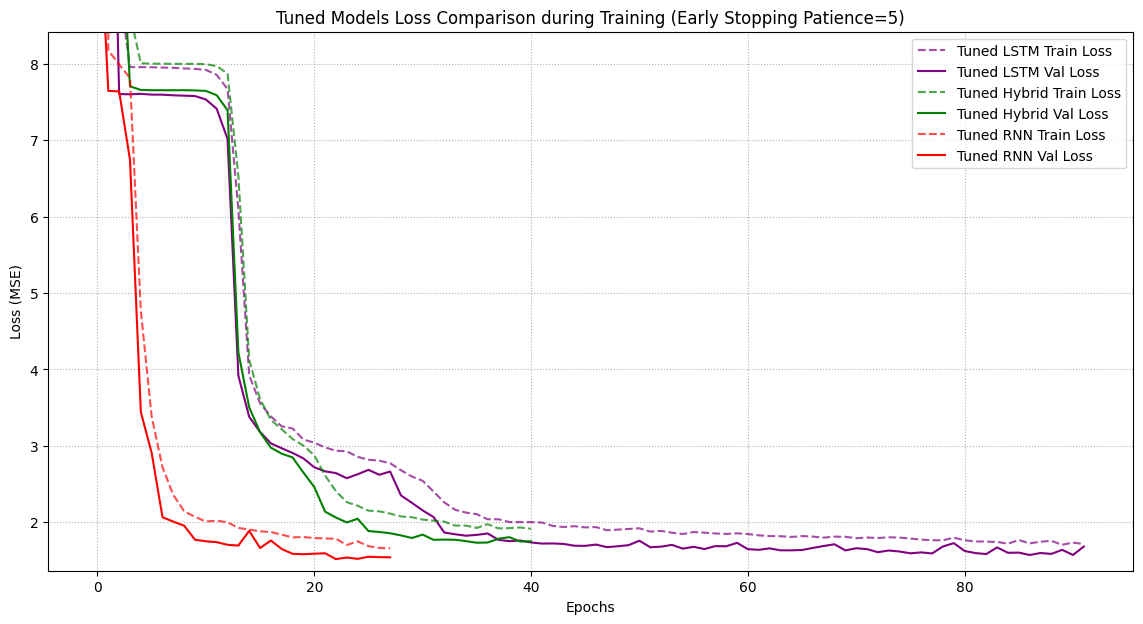

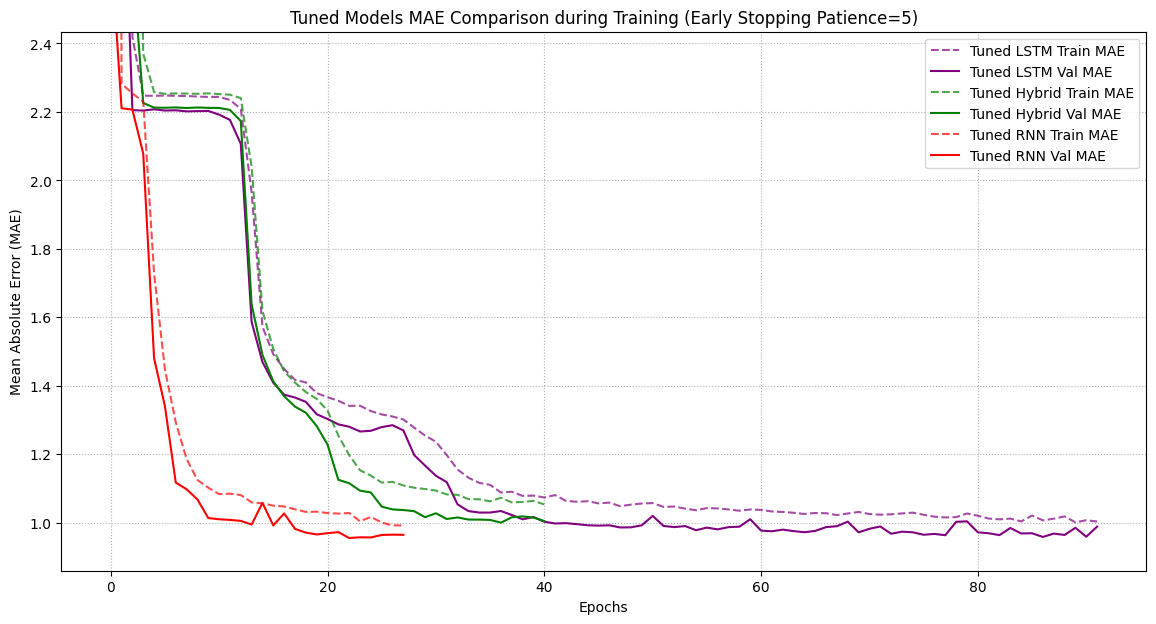

In [ ]:
# --- 15. Plotting Training History Comparison (Only Tuned Models) ---
print("\n--- 15. Plotting Training History (Only Tuned Models) ---")
plt.figure(figsize=(14, 7))

# Plotting Loss (Only Tuned Models)
plt.plot(lstm_tuned_history.history['loss'], label='Tuned LSTM Train Loss', color='purple', linestyle='--', alpha=0.7)
plt.plot(lstm_tuned_history.history['val_loss'], label='Tuned LSTM Val Loss', color='purple', linestyle='-', linewidth=1.5)
plt.plot(hybrid_tuned_history.history['loss'], label='Tuned Hybrid Train Loss', color='green', linestyle='--', alpha=0.7)
plt.plot(hybrid_tuned_history.history['val_loss'], label='Tuned Hybrid Val Loss', color='green', linestyle='-', linewidth=1.5)
plt.plot(rnn_tuned_history.history['loss'], label='Tuned RNN Train Loss', color='red', linestyle='--', alpha=0.7)
plt.plot(rnn_tuned_history.history['val_loss'], label='Tuned RNN Val Loss', color='red', linestyle='-', linewidth=1.5)

plt.title(f'Tuned Models Loss Comparison during Training (Early Stopping Patience={PATIENCE})')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle=':')
# Adjust ylim for better visibility, focusing on validation loss range
val_losses = np.concatenate([
    lstm_tuned_history.history['val_loss'],
    hybrid_tuned_history.history['val_loss'],
    rnn_tuned_history.history['val_loss']
])
min_val_loss = np.min(val_losses) if len(val_losses) > 0 else 0
max_val_loss = np.percentile(val_losses, 95) if len(val_losses) > 0 else 1
plt.ylim(bottom=min_val_loss * 0.9, top=max_val_loss * 1.1) # Show relevant range
plt.show()

# Plotting MAE (Only Tuned Models)
plt.figure(figsize=(14, 7))
plt.plot(lstm_tuned_history.history['mae'], label='Tuned LSTM Train MAE', color='purple', linestyle='--', alpha=0.7)
plt.plot(lstm_tuned_history.history['val_mae'], label='Tuned LSTM Val MAE', color='purple', linestyle='-', linewidth=1.5)
plt.plot(hybrid_tuned_history.history['mae'], label='Tuned Hybrid Train MAE', color='green', linestyle='--', alpha=0.7)
plt.plot(hybrid_tuned_history.history['val_mae'], label='Tuned Hybrid Val MAE', color='green', linestyle='-', linewidth=1.5)
plt.plot(rnn_tuned_history.history['mae'], label='Tuned RNN Train MAE', color='red', linestyle='--', alpha=0.7)
plt.plot(rnn_tuned_history.history['val_mae'], label='Tuned RNN Val MAE', color='red', linestyle='-', linewidth=1.5)

plt.title(f'Tuned Models MAE Comparison during Training (Early Stopping Patience={PATIENCE})')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True, linestyle=':')
val_maes = np.concatenate([
    lstm_tuned_history.history['val_mae'],
    hybrid_tuned_history.history['val_mae'],
    rnn_tuned_history.history['val_mae']
])
min_val_mae = np.min(val_maes) if len(val_maes) > 0 else 0
max_val_mae = np.percentile(val_maes, 95) if len(val_maes) > 0 else 1
plt.ylim(bottom=min_val_mae * 0.9, top=max_val_mae * 1.1) # Show relevant range
plt.show()

The code generates scatter plots to visualize the relationship between the actual and predicted values for both Tmax and Tmin, comparing the predictions for each of the tuned models (LSTM, Hybrid, and RNN). For each model, two plots are created:

Tmax Prediction Plot: Shows actual vs. predicted Tmax values along with an ideal fit line (y = x) and R² score for Tmax predictions.

Tmin Prediction Plot: Similar to Tmax but for Tmin predictions.

These plots help evaluate how well the models predict both Tmax and Tmin. The R² values for each plot provide insight into the model's accuracy for each variable.


--- 16. Plotting Predictions vs Actual ---


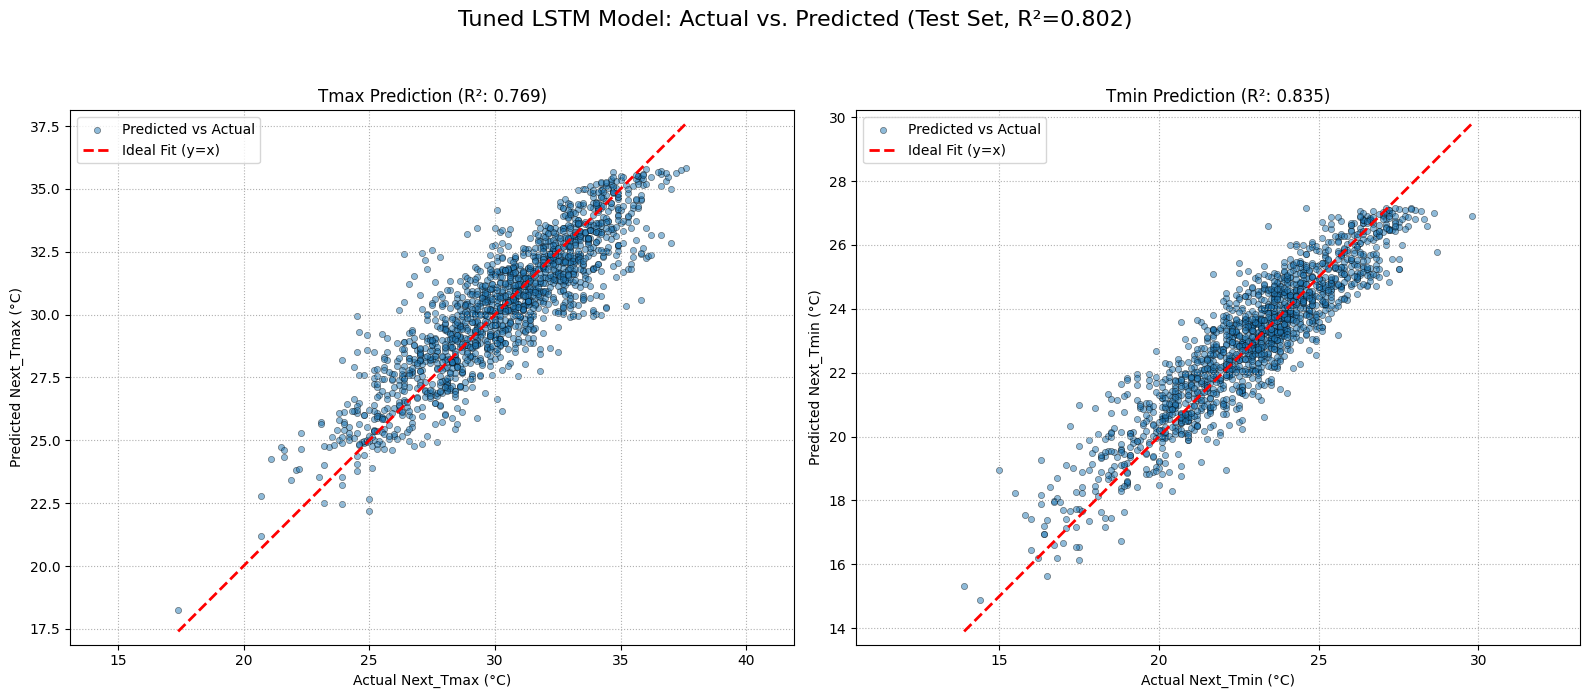

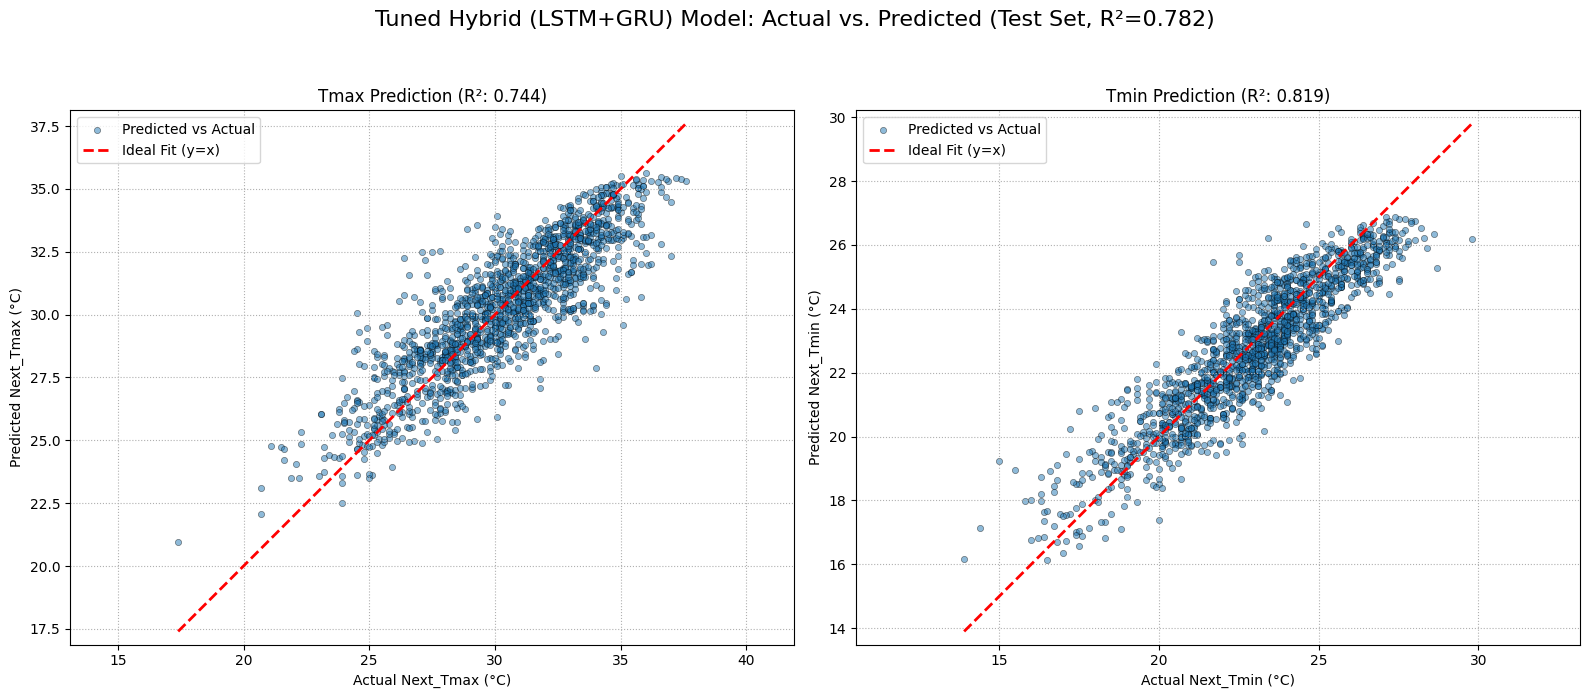

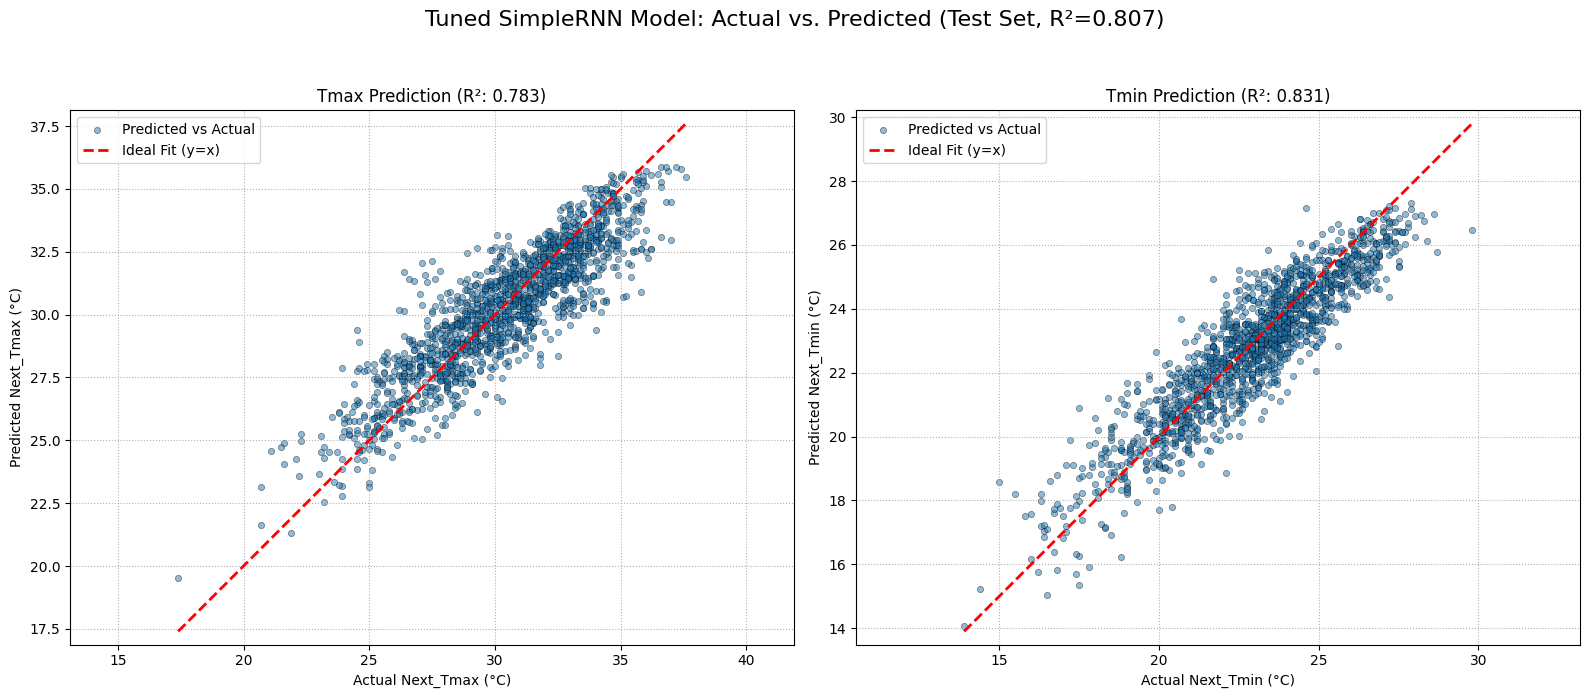

In [ ]:
# --- 16. Plotting Predictions vs Actual for Each Model ---
print("\n--- 16. Plotting Predictions vs Actual ---")

# Only tuned models for actual vs predicted plots
models_to_plot = [
    (best_lstm_model, "Tuned LSTM", lstm_tuned_predictions, lstm_tuned_r2),
    (best_hybrid_model, "Tuned Hybrid (LSTM+GRU)", hybrid_tuned_predictions, hybrid_tuned_r2),
    (best_rnn_model, "Tuned SimpleRNN", rnn_tuned_predictions, rnn_tuned_r2),
]

for model, model_name, predictions, r2_overall in models_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f"{model_name} Model: Actual vs. Predicted (Test Set, R²={r2_overall:.3f})", fontsize=16, y=1.02)

    # Calculate R² for Tmax and Tmin separately
    r2_tmax = r2_score(y_test[:, 0], predictions[:, 0])
    r2_tmin = r2_score(y_test[:, 1], predictions[:, 1])

    # Plot for Next_Tmax (Index 0)
    axes[0].scatter(y_test[:, 0], predictions[:, 0], alpha=0.5, label='Predicted vs Actual', s=20, edgecolors='k', linewidth=0.5)
    min_val_tmax = min(y_test[:, 0].min(), predictions[:, 0].min())
    max_val_tmax = max(y_test[:, 0].max(), predictions[:, 0].max())
    axes[0].plot([min_val_tmax, max_val_tmax], [min_val_tmax, max_val_tmax], 'r--', label='Ideal Fit (y=x)', linewidth=2)
    axes[0].set_xlabel("Actual Next_Tmax (°C)")
    axes[0].set_ylabel("Predicted Next_Tmax (°C)")
    axes[0].set_title(f"Tmax Prediction (R²: {r2_tmax:.3f})")
    axes[0].legend()
    axes[0].grid(True, linestyle=':')
    axes[0].axis('equal') # Ensure axes have the same scale

    # Plot for Next_Tmin (Index 1)
    axes[1].scatter(y_test[:, 1], predictions[:, 1], alpha=0.5, label='Predicted vs Actual', s=20, edgecolors='k', linewidth=0.5)
    min_val_tmin = min(y_test[:, 1].min(), predictions[:, 1].min())
    max_val_tmin = max(y_test[:, 1].max(), predictions[:, 1].max())
    axes[1].plot([min_val_tmin, max_val_tmin], [min_val_tmin, max_val_tmin], 'r--', label='Ideal Fit (y=x)', linewidth=2)
    axes[1].set_xlabel("Actual Next_Tmin (°C)")
    axes[1].set_ylabel("Predicted Next_Tmin (°C)")
    axes[1].set_title(f"Tmin Prediction (R²: {r2_tmin:.3f})")
    axes[1].legend()
    axes[1].grid(True, linestyle=':')
    axes[1].axis('equal') # Ensure axes have the same scale

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

Select Best Model: Based on the lowest MAE, the best model is chosen.

Prepare Data: The latest data point is extracted from the dataset to start the forecasting process.

Forecast for 7 Days: Using the selected model, it predicts the Tmax and Tmin for the next 7 days. The predictions are used iteratively, with each day's prediction feeding into the next day's forecast.

Display and Plot: The forecasted temperatures for each day are printed, and a plot visualizing the Tmax and Tmin forecasts is generated.


--- 17. Forecasting Next 7 Days ---

Temperature Forecasts for Next 7 Days:
Day 1: Tmax = 27.46°C, Tmin = 17.19°C
Day 2: Tmax = 32.41°C, Tmin = 25.48°C
Day 3: Tmax = 29.22°C, Tmin = 23.60°C
Day 4: Tmax = 28.52°C, Tmin = 23.15°C
Day 5: Tmax = 28.39°C, Tmin = 23.07°C
Day 6: Tmax = 28.36°C, Tmin = 23.05°C
Day 7: Tmax = 28.36°C, Tmin = 23.05°C


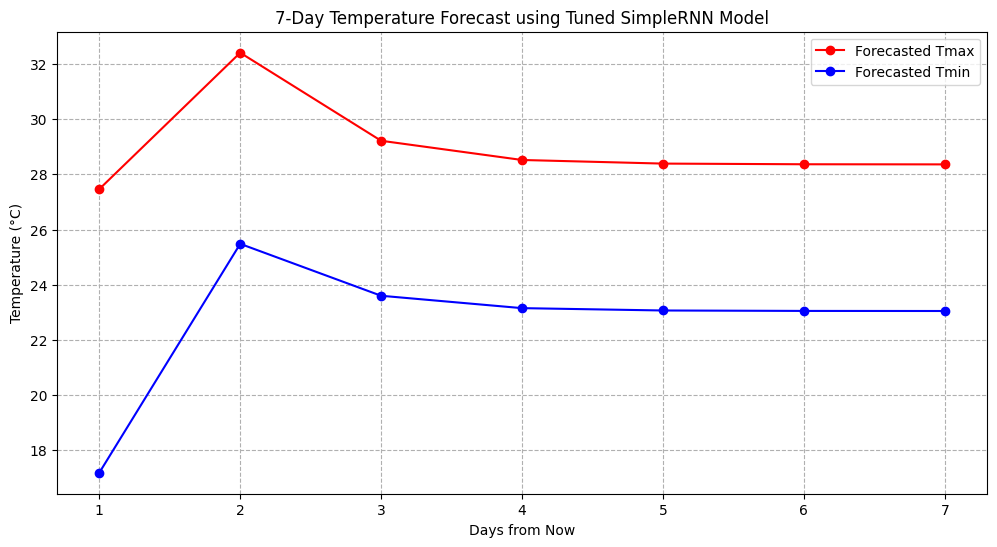

In [ ]:
# --- 17. Forecasting Next 7 Days ---
print("\n--- 17. Forecasting Next 7 Days ---")

# Select the best model based on previous evaluation (lowest MAE)
if best_model_name == 'Tuned LSTM':
    forecasting_model = best_lstm_model
elif best_model_name == 'LSTM':
    forecasting_model = lstm_model
elif best_model_name == 'Hybrid (LSTM+GRU)':
    forecasting_model = hybrid_model
else: # SimpleRNN
    forecasting_model = rnn_model

# Get the most recent data point for starting the forecast
latest_data_point = X_scaled[-1].reshape(1, -1)  # Last data point in dataset

# Initialize array to store forecasts
forecasts = []

# Deep copy of the latest data for manipulation
current_input = latest_data_point.copy()

# Track our predictions to use them as inputs for subsequent days
predicted_tmax = []
predicted_tmin = []

# Get positions of relevant features in the data
# These positions will depend on your actual dataset column ordering
tmax_position = feature_cols.index('Present_Tmax') if 'Present_Tmax' in feature_cols else None
tmin_position = feature_cols.index('Present_Tmin') if 'Present_Tmin' in feature_cols else None

# Generate forecasts for 7 days
for day in range(7):
    # Reshape for model input
    model_input = current_input.reshape(1, timesteps, features_per_timestep)

    # Make prediction for current day
    next_day_pred = forecasting_model.predict(model_input, verbose=0)
    forecasts.append(next_day_pred[0])

    # Store predictions for use in next iteration
    predicted_tmax.append(next_day_pred[0][0])
    predicted_tmin.append(next_day_pred[0][1])

    # Update inputs for next prediction - shift necessary features
    if day < 6:  # Only update for days 0-5 (to predict days 1-6)
        # Deep copy to avoid modifying original data
        next_input = current_input.copy()

        # Update temperature features if available
        if tmax_position is not None:
            next_input[0, tmax_position] = next_day_pred[0][0]  # Use predicted Tmax
        if tmin_position is not None:
            next_input[0, tmin_position] = next_day_pred[0][1]  # Use predicted Tmin

        # For demo purposes, you could also update other features
        # (in a real forecasting scenario, you'd have external data sources for this)

        # Update current input for next iteration
        current_input = next_input

# Convert forecasts to a numpy array
forecasts = np.array(forecasts)

# Display the forecasts
print("\nTemperature Forecasts for Next 7 Days:")
for day, forecast in enumerate(forecasts, 1):
    print(f"Day {day}: Tmax = {forecast[0]:.2f}°C, Tmin = {forecast[1]:.2f}°C")

# Plot the forecasts
plt.figure(figsize=(12, 6))
days = list(range(1, 8))
plt.plot(days, forecasts[:, 0], 'ro-', label='Forecasted Tmax')
plt.plot(days, forecasts[:, 1], 'bo-', label='Forecasted Tmin')
plt.title(f'7-Day Temperature Forecast using {best_model_name} Model')
plt.xlabel('Days from Now')
plt.ylabel('Temperature (°C)')
plt.xticks(days)
plt.grid(True, linestyle='--')
plt.legend()
plt.show()